# Chapter 16: Decline Curve Analysis (DCA) with Scipy
**Author:** Ade Anggi Naluriawan Santoso

**Objective:**
In this notebook, we will use Python to automatically fit Arps' decline curve parameters ($q_i, D_i, b$) to production data. This allows us to forecast future production and estimate reserves (EUR).

**The Theory (Arps, 1945):**
The general hyperbolic decline equation is:

$$q(t) = \frac{q_i}{(1 + b D_i t)^{1/b}}$$

Where:
* $q(t)$: Production rate at time $t$.
* $q_i$: Initial production rate ($t=0$).
* $D_i$: Initial nominal decline rate.
* $b$: Hyperbolic decline exponent (curvature).
    * $b=0$: **Exponential** (Straight line on semilog).
    * $0 < b < 1$: **Hyperbolic** (Curved on semilog).
    * $b=1$: **Harmonic**.

**The Goal:**
We want to find the combination of $(q_i, D_i, b)$ that minimizes the error between the equation and our actual production data. We will use the **Levenberg-Marquardt algorithm** via `scipy.optimize.curve_fit`.

--- Production History Sample ---
   Time_Day    Rate_STBD
0         0  1024.835708
1         1   988.138678
2         2  1022.132418
3         3  1060.177201
4         4   968.799922


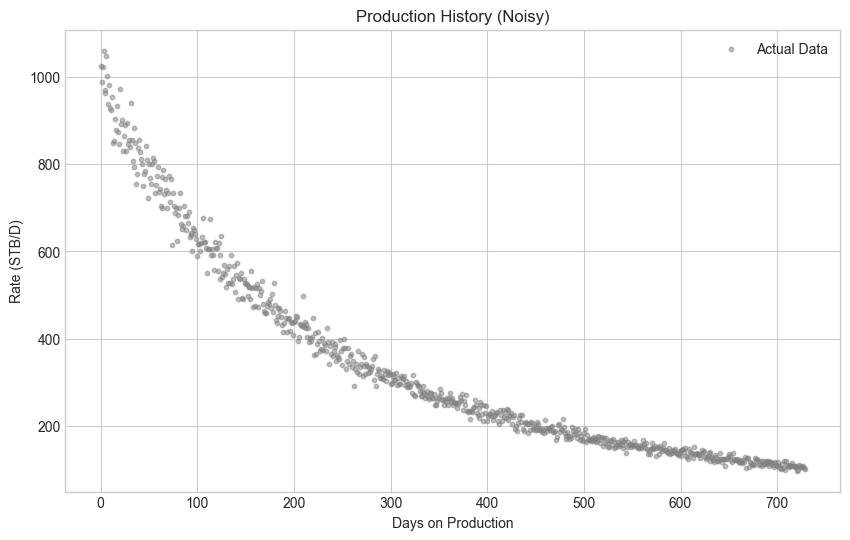

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# --- 1. GENERATE SYNTHETIC DATA ---
# In real life, you would load this from a CSV.
# We create a "Truth" case with some noise to simulate real field data.

# Truth Parameters
qi_true = 1000.0  # STB/D
di_true = 0.005   # Nominal daily decline (approx 0.5% per day)
b_true  = 0.4     # Typical hyperbolic behavior

# Time: 2 years of history (730 days)
t_history = np.arange(0, 730, 1)

# Generate Rates with Noise
noise_level = 0.05 # 5% random noise
np.random.seed(42) # For reproducibility

q_pure = qi_true / ((1 + b_true * di_true * t_history)**(1/b_true))
q_noisy = q_pure * (1 + noise_level * np.random.normal(size=len(t_history)))

# Create DataFrame
df_hist = pd.DataFrame({'Time_Day': t_history, 'Rate_STBD': q_noisy})

print("--- Production History Sample ---")
print(df_hist.head())

# Plot the noisy data
plt.figure()
plt.scatter(df_hist['Time_Day'], df_hist['Rate_STBD'], s=10, color='gray', alpha=0.5, label='Actual Data')
plt.title('Production History (Noisy)')
plt.xlabel('Days on Production')
plt.ylabel('Rate (STB/D)')
plt.legend()
plt.show()

## 1. Defining the Model

We need a Python function that represents Arps' equation. The optimization library will pass time arrays into this function and adjust `qi`, `di`, and `b` to match the output.

*Note: The equation becomes undefined if $b=0$ exactly (division by zero). In practice, we usually constrain $b$ to be slightly positive (e.g., $10^{-6}$) or use a separate Exponential function if $b \approx 0$. For this exercise, we fit the general hyperbolic form.*

In [2]:
def arps_hyperbolic(t, qi, di, b):
    """
    Arps Hyperbolic Rate Equation.
    """
    # Safety: Ensure term inside power is positive and b is not zero
    # We essentially "clip" b to avoid numerical errors during optimization steps
    if abs(b) < 1e-6:
        b = 1e-6
        
    return qi / ((1 + b * di * t)**(1/b))

def arps_exponential(t, qi, di):
    """
    Arps Exponential Rate Equation (b=0 limit).
    """
    return qi * np.exp(-di * t)

## 2. Fitting the Curve (Optimization)

We use `curve_fit`. It is crucial to provide **Bounds** and **Initial Guesses ($p_0$)**.
* Without bounds, the solver might try negative decline rates (increasing production) or negative $b$ values, which are physically impossible for this model.

**Constraints:**
* $q_i$: $0$ to $\infty$
* $D_i$: $0$ to $\infty$
* $b$: $0$ to $1$ (Typical reservoir engineering bounds)

In [3]:
# Prepare Data for Fitting
x_data = df_hist['Time_Day'].values
y_data = df_hist['Rate_STBD'].values

# Initial Guesses (p0): [qi, di, b]
# It's good to guess qi close to the first data point
p0_guess = [max(y_data), 0.01, 0.5]

# Bounds: ([low_qi, low_di, low_b], [high_qi, high_di, high_b])
bounds = ([0, 0, 0.0], [np.inf, np.inf, 1.0])

try:
    # Perform Optimization
    popt, pcov = curve_fit(arps_hyperbolic, x_data, y_data, p0=p0_guess, bounds=bounds)
    
    # Extract fitted parameters
    qi_fit, di_fit, b_fit = popt
    
    print(f"--- FITTED PARAMETERS ---")
    print(f"qi (True: {qi_true}):  {qi_fit:.2f} STB/D")
    print(f"di (True: {di_true}):  {di_fit:.5f} /day")
    print(f"b  (True: {b_true}):   {b_fit:.3f}")
    
except Exception as e:
    print(f"Fitting failed: {e}")

--- FITTED PARAMETERS ---
qi (True: 1000.0):  991.25 STB/D
di (True: 0.005):  0.00489 /day
b  (True: 0.4):   0.384


## 3. Visualization and Forecasting

Now that we have the parameters, we can:
1.  Plot the fitted curve over the historical data to check quality.
2.  **Forecast** future production (e.g., next 5 years).
3.  Calculate **EUR (Estimated Ultimate Recovery)**.

**EUR Calculation:**
For hyperbolic decline, cumulative production $N_p$ at time $t$ is:
$$N_p(t) = \frac{q_i^b}{D_i(1-b)} \left[ q_i^{1-b} - q(t)^{1-b} \right]$$

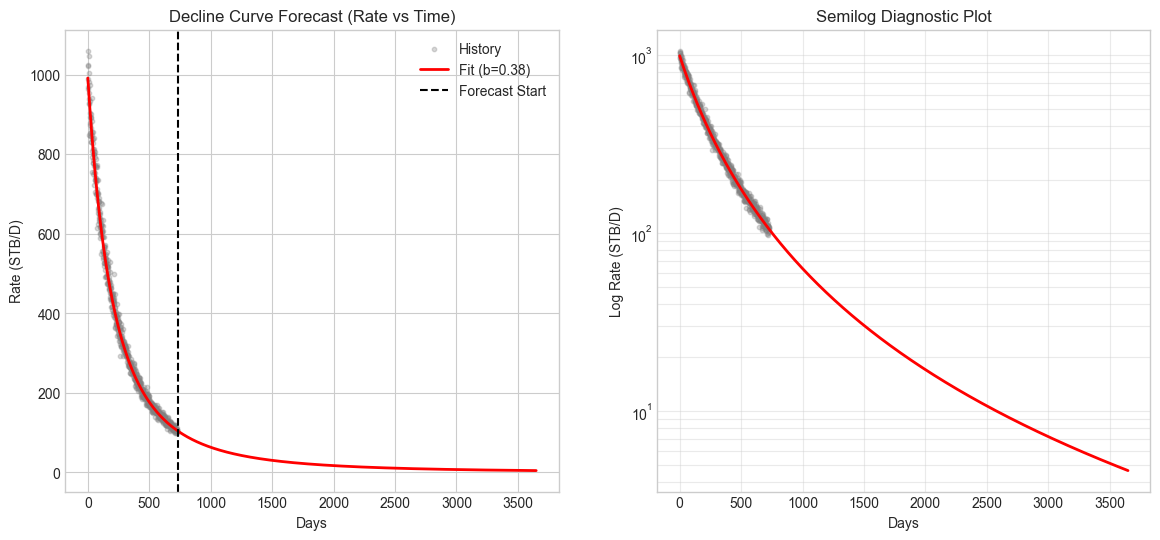

--- RESERVES ESTIMATION ---
Forecasted rate at Year 10: 4.6 STB/D
10-Year Cumulative Oil (EUR): 317.0 MSTB


In [4]:
# --- 1. GENERATE FORECAST ---
# Forecast for 10 years (3650 days total)
t_forecast = np.arange(0, 3650, 1)

# Calculate rates using fitted parameters
q_forecast = arps_hyperbolic(t_forecast, qi_fit, di_fit, b_fit)

# --- 2. CALCULATE CUMULATIVE (Np) ---
# We can integrate numerically using typical trapezoidal rule or use the analytical formula
# Let's use analytical formula for Hyperbolic Cum
def calculate_cum_hyperbolic(qi, di, b, qt):
    term1 = (qi**b) / (di * (1-b))
    term2 = (qi**(1-b)) - (qt**(1-b))
    return term1 * term2

# Calculate EUR at the end of 10 years
q_abandonment = q_forecast[-1]
EUR_10yr = calculate_cum_hyperbolic(qi_fit, di_fit, b_fit, q_abandonment)

# --- 3. PLOTTING ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Rate vs Time (The Decline Curve)
ax1.scatter(df_hist['Time_Day'], df_hist['Rate_STBD'], s=10, color='gray', alpha=0.3, label='History')
ax1.plot(t_forecast, q_forecast, 'r-', linewidth=2, label=f'Fit (b={b_fit:.2f})')
ax1.axvline(730, color='k', linestyle='--', label='Forecast Start')

ax1.set_title('Decline Curve Forecast (Rate vs Time)')
ax1.set_xlabel('Days')
ax1.set_ylabel('Rate (STB/D)')
ax1.legend()
ax1.grid(True)

# Plot 2: Semilog View (Standard Industry View)
ax2.scatter(df_hist['Time_Day'], df_hist['Rate_STBD'], s=10, color='gray', alpha=0.3)
ax2.plot(t_forecast, q_forecast, 'r-', linewidth=2)
ax2.set_yscale('log') # The magic line for engineers
ax2.set_title('Semilog Diagnostic Plot')
ax2.set_xlabel('Days')
ax2.set_ylabel('Log Rate (STB/D)')
ax2.grid(True, which="both", ls="-", alpha=0.4)

plt.show()

print(f"--- RESERVES ESTIMATION ---")
print(f"Forecasted rate at Year 10: {q_abandonment:.1f} STB/D")
print(f"10-Year Cumulative Oil (EUR): {EUR_10yr/1000:.1f} MSTB")

## Conclusion

1.  **Automation:** We fit a complex non-linear equation to noisy data in milliseconds.
2.  **Parameter Extraction:** We successfully recovered the true parameters (within noise tolerance).
3.  **Forecasting:** We projected the curve to estimate reserves.

**Advanced Note:** In unconventional reservoirs (shale), $b$ often fits to values $>1$. If you encounter this, you must change the bounds in `curve_fit` to allow $b > 1$, but be aware that the infinite-time cumulative production for $b \ge 1$ is undefined (infinite) without an abandonment rate cutoff.